In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [5]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import tensorflow as tf
import numpy as np
from pathlib import Path
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
import matplotlib.pyplot as plt
import yfinance as yf
import plotly.graph_objects as go

2024-03-17 18:46:24.937529: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [76]:
# Define the stock symbols for the financial institutions we're interested in
stock_symbols = ['AAPL', 'KO', 'NKE', 'EA']
# Define the start and end dates for our data
start_date = '2020-01-01'
end_date = '2024-03-15'

# Function to download stock data
def download_stock_data(symbols):
    data = {}
    for symbol in symbols:
        data[symbol] = yf.download(symbol, start=start_date, end=end_date)
    return data

# Download stock data
stocks_data = download_stock_data(stock_symbols)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [77]:
# Display the first few rows of Apple's stock data
print(stocks_data['AAPL'].tail())

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-03-08  169.000000  173.699997  168.940002  170.729996  170.729996   
2024-03-11  172.940002  174.380005  172.050003  172.750000  172.750000   
2024-03-12  173.149994  174.029999  171.009995  173.229996  173.229996   
2024-03-13  172.770004  173.190002  170.759995  171.130005  171.130005   
2024-03-14  172.910004  174.309998  172.050003  173.000000  173.000000   

              Volume  
Date                  
2024-03-08  76114600  
2024-03-11  60139500  
2024-03-12  59825400  
2024-03-13  52488700  
2024-03-14  72913500  


In [78]:
# Calculate technical indicators and OHLC ratios for stock
def calculate_features(data):
    # Moving Average
    data['MA_10'] = data['Close'].rolling(window=10).mean()
    # Exponential Moving Average
    data['EMA_10'] = data['Close'].ewm(span=10, adjust=False).mean()
    
    # Relative Strength Index (RSI)
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))
    
    # OHLC Ratios
    data['HLC_Ratio'] = (data['High'] - data['Low']) / data['Close']
    data['OC_Ratio'] = (data['Open'] - data['Close']) / data['Close']
    
    # Drop NaN values generated by moving averages and RSI
    data.dropna(inplace=True)
    return data

# Apply feature engineering to stocks
for symbol in stocks_data:
    stocks_data[symbol] = calculate_features(stocks_data[symbol])

In [79]:
df2 = stocks_data['AAPL']
df2

,Open,High,Low,Close,Adj Close,Volume,MA_10,EMA_10,RSI,HLC_Ratio,OC_Ratio
Date,,,,,,,,,,,
2020-01-22,79.644997,79.997498,79.327499,79.425003,77.279770,101832400,78.309250,78.255756,70.868434,0.008436,0.002770
2020-01-23,79.480003,79.889999,78.912498,79.807503,77.651939,104472000,78.710250,78.537892,71.902570,0.012248,-0.004104
2020-01-24,80.062500,80.832497,79.379997,79.577499,77.428146,146537600,78.927250,78.726911,75.401481,0.018253,0.006095
2020-01-27,77.514999,77.942497,76.220001,77.237503,75.151352,161940000,78.892751,78.456110,59.513444,0.022301,0.003593
2020-01-28,78.150002,79.599998,78.047501,79.422501,77.277351,162234000,78.911001,78.631817,67.412481,0.019547,-0.016022
...,...,...,...,...,...,...,...,...,...,...,...
2024-03-08,169.000000,173.699997,168.940002,170.729996,170.729996,76114600,175.969000,174.738135,25.466088,0.027880,-0.010133
2024-03-11,172.940002,174.380005,172.050003,172.750000,172.750000,60139500,175.128000,174.376656,32.287898,0.013488,0.001100
2024-03-12,173.149994,174.029999,171.009995,173.229996,173.229996,59825400,174.187999,174.168173,31.516839,0.017433,-0.000462


In [80]:
df2 = df2['Close']

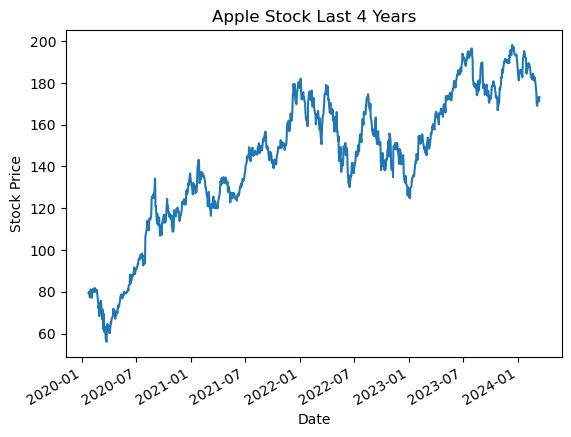

In [81]:
#Make plot
df2.plot(y='Close', kind='line', linestyle='-')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Apple Stock Last 4 Years')

# Show the plot
plt.show()

In [82]:
# Scale the data
scaler = MinMaxScaler()
df2 = scaler.fit_transform(np.array(df2).reshape(-1,1))
df2.shape

(1044, 1)

In [83]:
# Separate data points, not currently using valid_data but could use if we pulled more of the dataset.
train_data=df2[0:1030]
valid_data=df2[1030:,]

# Create train and testing sizes
train_size = int(len(df2)*0.80)
test_size = len(df2) - train_size
train_data, test_data = df2[:train_size], df2[train_size:]

In [84]:
# Using def to create dataset lists for training
def create_dataset(data, time_step = 1):
    dataX,dataY = [],[]
    for i in range(len(data)-time_step-1):
                   a = data[i:(i+time_step),0]
                   dataX.append(a)
                   dataY.append(data[i + time_step,0])
    return np.array(dataX),np.array(dataY)

In [85]:
# Set variables to start training and testing data
time_step = 100
X_train, Y_train =  create_dataset(train_data, time_step)
X_test, Y_test =  create_dataset(test_data, time_step)

In [86]:
# checking values
print(X_train.shape)
print(X_train)
print(X_test.shape)
print(Y_test.shape)

(734, 100)
[[0.16429316 0.16698649 0.16536695 ... 0.22615171 0.19633143 0.20143643]
 [0.16698649 0.16536695 0.14889013 ... 0.19633143 0.20143643 0.20881228]
 [0.16536695 0.14889013 0.16427554 ... 0.20143643 0.20881228 0.22481383]
 ...
 [0.61342797 0.56618023 0.55216783 ... 0.82720444 0.82671149 0.81452993]
 [0.56618023 0.55216783 0.53709927 ... 0.82671149 0.81452993 0.82713396]
 [0.55216783 0.53709927 0.53660643 ... 0.81452993 0.82713396 0.82847184]]
(108, 100)
(108,)


In [87]:
# Create the model
stock_model = Sequential()
stock_model.add(LSTM(50,return_sequences = True,input_shape = (X_train.shape[1],1)))
stock_model.add(LSTM(50,return_sequences = True))
stock_model.add(LSTM(50))
stock_model.add(Dense(1))
stock_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [88]:
#Fit the model
stock_model.fit(X_train,Y_train,validation_data = (X_test,Y_test),epochs = 20,batch_size = 32,verbose = 1)

Epoch 1/20
23/23 [==============================] - 7s 122ms/step - loss: 0.0728 - val_loss: 0.0095
Epoch 2/20
23/23 [==============================] - 2s 88ms/step - loss: 0.0056 - val_loss: 0.0093
Epoch 3/20
23/23 [==============================] - 2s 82ms/step - loss: 0.0037 - val_loss: 0.0070
Epoch 4/20
23/23 [==============================] - 2s 79ms/step - loss: 0.0031 - val_loss: 0.0067
Epoch 5/20
23/23 [==============================] - 2s 78ms/step - loss: 0.0028 - val_loss: 0.0040
Epoch 6/20
23/23 [==============================] - 2s 81ms/step - loss: 0.0027 - val_loss: 0.0034
Epoch 7/20
23/23 [==============================] - 2s 78ms/step - loss: 0.0026 - val_loss: 0.0034
Epoch 8/20
23/23 [==============================] - 2s 80ms/step - loss: 0.0024 - val_loss: 0.0027
Epoch 9/20
23/23 [==============================] - 2s 77ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 10/20
23/23 [==============================] - 2s 76ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 11

In [89]:
#Use model to predict
train_predict = stock_model.predict(X_train)
test_predict = stock_model.predict(X_test)

4/4 [==============================] - 0s 25ms/step


In [90]:
# transform to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [91]:
model_predictions = stock_model.predict(X_train)
true_labels = Y_train

23/23 [==============================] - 1s 25ms/step


In [92]:
#Pull metrics to test accuracy
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(true_labels, model_predictions)
print("Mean Absolute Error (MAE):", mae)

# Compute Mean Squared Error (MSE)
mse = mean_squared_error(true_labels, model_predictions)
print("Mean Squared Error (MSE):", mse)

# Compute R^2 Score
r2 = r2_score(true_labels, model_predictions)
print("R^2 Score:", r2)

Mean Absolute Error (MAE): 0.029823767606506228
Mean Squared Error (MSE): 0.001408723935195832
R^2 Score: 0.9323713078625302


In [93]:
# Create variables to plot
look_back = 100

trainPredictPlot = np.empty_like(df2)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back : len(train_predict)+look_back,:] = train_predict

testPredictPlot = np.empty_like(df2)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back)*2 + 1 : len(df2) - 1,:] = test_predict

In [94]:
trainPredictPlot = pd.DataFrame(trainPredictPlot)
trainPredictPlot[800:]

,0
800,156.309860
801,157.234009
802,157.971115
803,158.607056
804,159.211502
...,...
1039,NaN
1040,NaN
1041,NaN
1042,NaN


In [95]:
#Transform back to normal values
df2 = scaler.inverse_transform(df2)

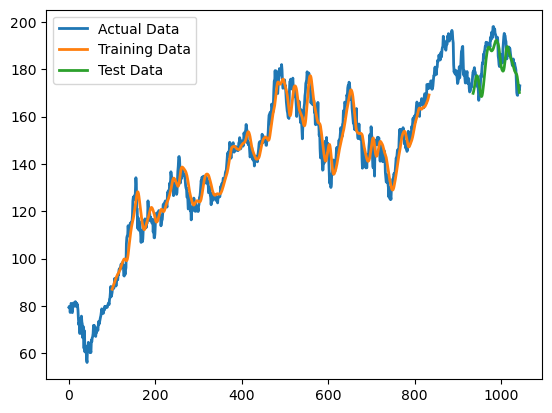

In [96]:
#Create overlapping plots of data, testing data, and training data
plt.plot(df2, label="Actual Data", linewidth=2)
plt.plot(trainPredictPlot, label="Training Data", linewidth=2)
plt.plot(testPredictPlot, label="Test Data", linewidth=2)

plt.legend()
plt.show()

In [97]:
# Number of future days to predict
future_days = 1
future_predictions = []
last_sequence = X_test[-1].reshape(1, -1)

for i in range(future_days):
    # Predict the next day's value with last sequence
    next_prediction = stock_model.predict(last_sequence)
    # Inverse transform to get the actual predicted value
    next_prediction = scaler.inverse_transform(next_prediction)
    # Append the prediction to the list of future predictions
    future_predictions.append(next_prediction)
    # Update last_sequence for the next prediction
    last_sequence = next_prediction.reshape(1, -1)

1/1 [==============================] - 0s 26ms/step


In [98]:
future_predictions

[array([[170.21803]], dtype=float32)]

In [99]:
df2 = pd.DataFrame(df2)

In [100]:
df2[['Close']] = df2

In [101]:
df2 = df2[['Close']]
df2

,Close
0,79.425003
1,79.807503
2,79.577499
3,77.237503
4,79.422501
...,...
1039,170.729996
1040,172.750000
1041,173.229996
1042,171.130005


In [102]:
# Add prediction to dataframe for side-by-side comparison of day's closing price and next day's prediction
model_data=df2[:1044]
predict_data=df2[1043:]
predict_data['Predictions']=next_prediction
print(predict_data)
print(f'Predicted Closing Price for February 28th, 2024:{next_prediction}')

      Close  Predictions
1043  173.0   170.218033
Predicted Closing Price for February 28th, 2024:[[170.21803]]


/var/folders/by/st2c4w_96757fgwg7jsfc4480000gn/T/ipykernel_53507/3112199961.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



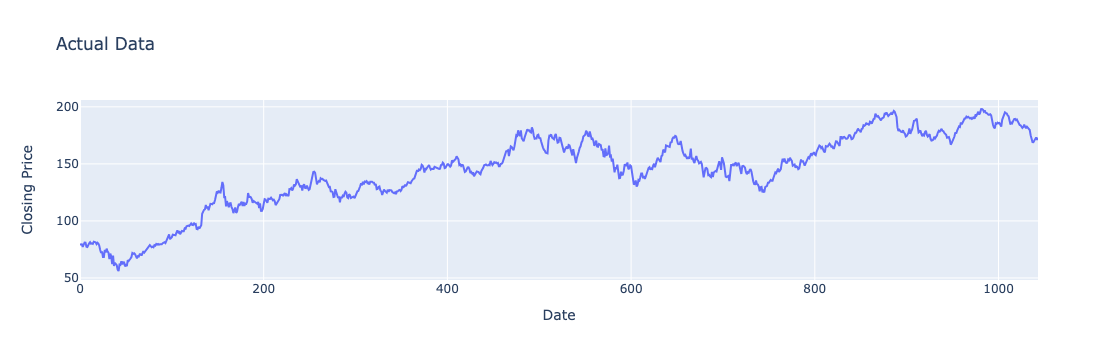

In [103]:
# Create traces
trace1 = go.Scatter(x=df2.index, y=df2['Close'], mode='lines', name='Actual Data', line=dict(width=2))

# Plot layout
layout = go.Layout(
    title='Actual Data',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Closing Price'),
    legend=dict(x=0, y=1, traceorder="normal")
)

# Create figure
fig = go.Figure(data=[trace1], layout=layout)

# Show plot
fig.show()

In [104]:
print("trainPredictPlot values:", trainPredictPlot)
print("testPredictPlot values:", testPredictPlot)

trainPredictPlot values:        0
0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
...   ..
1039 NaN
1040 NaN
1041 NaN
1042 NaN
1043 NaN

[1044 rows x 1 columns]
testPredictPlot values: [[         nan]
 [         nan]
 [         nan]
 ...
 [171.34353638]
 [170.2180481 ]
 [         nan]]


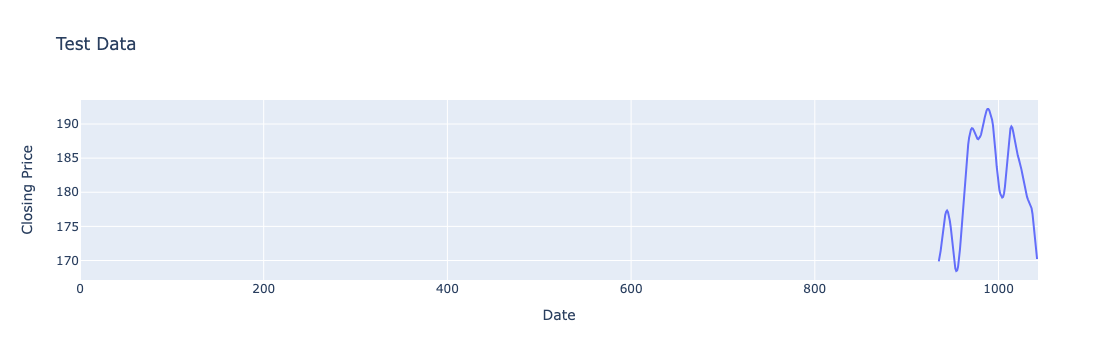

In [105]:
trace_test = go.Scatter(x=df2.index[len(df2) - len(testPredictPlot):], y=testPredictPlot.flatten(), mode='lines', name='Test Data', line=dict(width=2))

# Plot layout for test data
layout_test = go.Layout(
    title='Test Data',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Closing Price'),
    legend=dict(x=0, y=1, traceorder="normal")
)

# Create figure for test data
fig_test = go.Figure(data=[trace_test], layout=layout_test)

# Show plot for test data
fig_test.show()

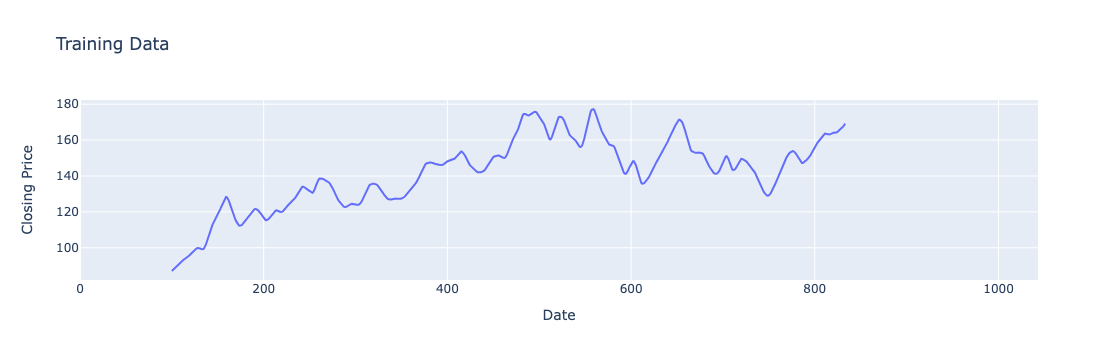

In [106]:
# Create trace for training data
trace_train = go.Scatter(x=df2.index[:len(trainPredictPlot)], y=trainPredictPlot.values.flatten(), mode='lines', name='Training Data', line=dict(width=2))

# Plot layout for training data
layout_train = go.Layout(
    title='Training Data',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Closing Price'),
    legend=dict(x=0, y=1, traceorder="normal")
)

# Create figure for training data
fig_train = go.Figure(data=[trace_train], layout=layout_train)

# Show plot for training data
fig_train.show()

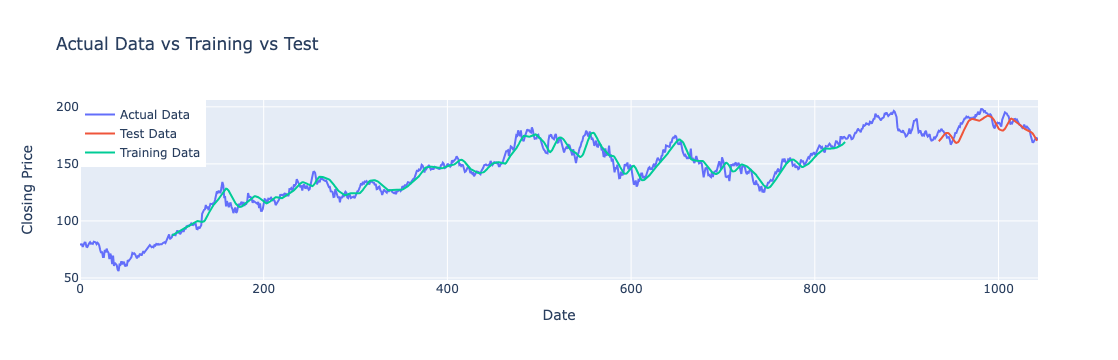

In [107]:
# Create traces for all three datasets
trace_actual = go.Scatter(x=df2.index, y=df2['Close'], mode='lines', name='Actual Data', line=dict(width=2))
trace_test = go.Scatter(x=df2.index[len(df2) - len(testPredictPlot):], y=testPredictPlot.flatten(), mode='lines', name='Test Data', line=dict(width=2))
trace_train = go.Scatter(x=df2.index[:len(trainPredictPlot)], y=trainPredictPlot.values.flatten(), mode='lines', name='Training Data', line=dict(width=2))

# Plot layout for all datasets
layout_all = go.Layout(
    title='Actual Data vs Training vs Test',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Closing Price'),
    legend=dict(x=0, y=1, traceorder="normal")
)

# Create figure for all datasets
fig_all = go.Figure(data=[trace_actual, trace_test, trace_train], layout=layout_all)

# Show plot for all datasets
fig_all.show()